In [1]:
!pip install --no-cache-dir numpy==1.23.5 scikit-learn==1.2.2 transformers==4.38.2 huggingface_hub==0.22.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 155.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 216.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 343.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 244.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.30.2
    Uninstalling huggingface-hub-0.30.2:
      Successfully uninstalled huggingface-hub-0.30.2
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 4638/4638 [14:39<00:00,  5.27it/s]


Train Acc: 0.8128 | Val Acc: 0.8310


Epoch 2: 100%|██████████| 4638/4638 [14:39<00:00,  5.27it/s]


Train Acc: 0.8604 | Val Acc: 0.8373
submission.csv saved!
Validation Accuracy: 0.8373195584489103
Precision: 0.8373341131728614
Recall: 0.8373195584489103
F1 Score: 0.8373178348925955


Computing ROC: 100%|██████████| 1325/1325 [01:27<00:00, 15.10it/s]


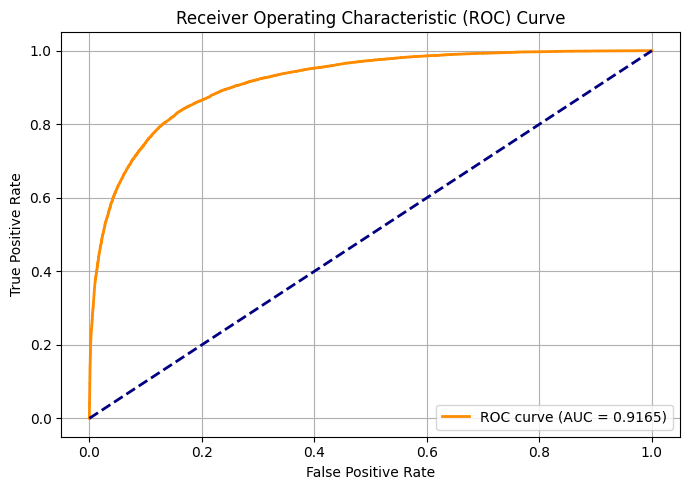

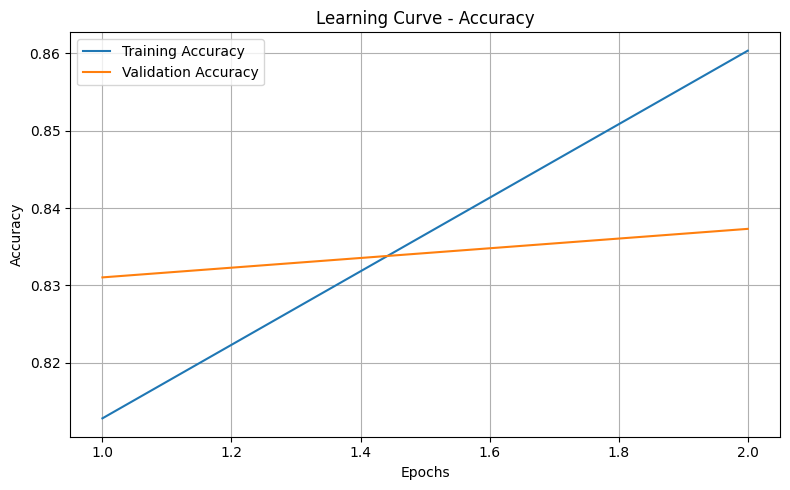

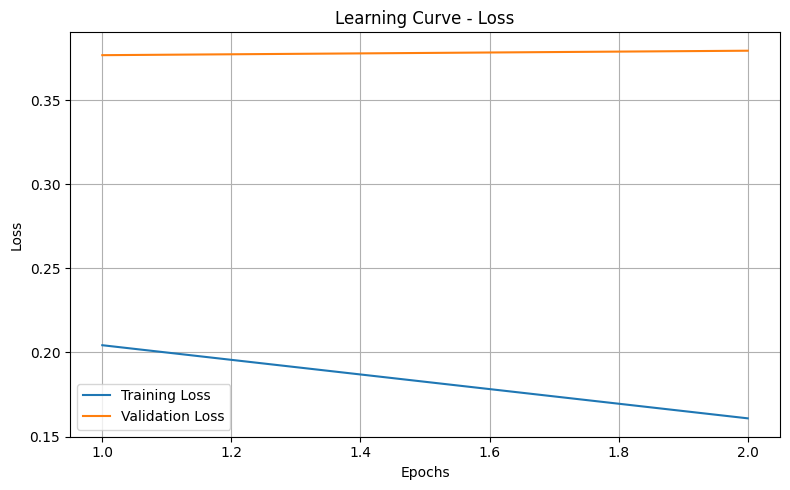

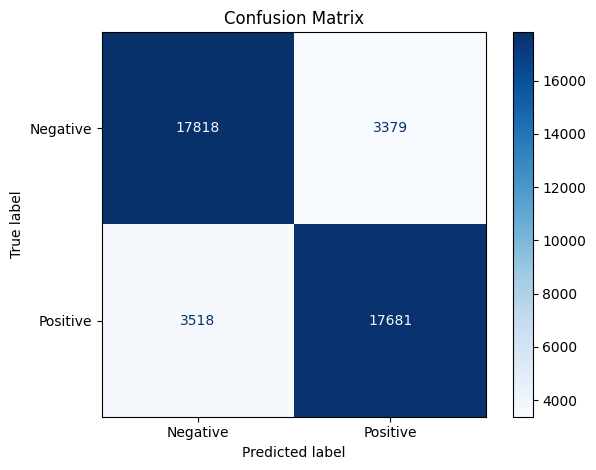

In [2]:
!pip install nltk
import nltk
nltk.download('omw-1.4')

from transformers import DistilBertTokenizer
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import re, random, numpy as np
from nltk.stem import WordNetLemmatizer
from transformers import DistilBertModel
import torch.nn as nn
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Lemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def cleaning(text):
    text = text.lower()
    text = re.sub(r'@\w+', '<user>', text)
    text = re.sub(r'#\w+', '<hashtag>', text)
    text = re.sub(r'http\S+|www\S+', '<url>', text) 
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    slang_dict = {
        r'\bur\b': 'your', r'\bu\b': 'you', r'\br\b': 'are',
        r'\bbrb\b': 'be right back', r'\bbtw\b': 'by the way',
        r'\blol\b': 'laughing out loud', r'\bomg\b': 'oh my god',
        r'\btmr\b': 'tomorrow', r'\bppl\b': 'people',
        r'\bidk\b': 'i do not know', r'\bimo\b': 'in my opinion',
        r'\bimho\b': 'in my humble opinion', r'\bwanna\b': 'want to',
        r'\bgonna\b': 'going to', r'\bgotta\b': 'got to',
        r'\bcuz\b': 'because', r'\bcoz\b': 'because', r'\bnvm\b': 'nevermind',
        r'\bya\b': 'yes', r'\byeah\b': 'yes', r'\blmk\b': 'let me know',
        r'\bttyl\b': 'talk to you later'
    }
    for k, v in slang_dict.items():
        text = re.sub(k, v, text)

    text = re.sub(r"\bi['’]?m\b", "i am", text)
    text = re.sub(r"\bdon['’]?t\b", "do not", text)
    text = re.sub(r"\bdoesn['’]?t\b", "does not", text)
    text = re.sub(r"\bhaven['’]?t\b", "have not", text)
    text = re.sub(r"\bhasn['’]?t\b", "has not", text)
    text = re.sub(r"\bcan['’]?t\b", "can not", text)
    text = re.sub(r"\bur\b", "you are", text)
    text = re.sub(r"\bure\b", "you are", text)

    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Διαβάζουμε τα datasets από το Kaggle path
train_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/train_dataset.csv")
val_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/val_dataset.csv")
test_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3-distil-bert/test_dataset.csv")

# Εφαρμογή preprocessing
train_texts = [cleaning(t) for t in train_df.Text.tolist()]
val_texts = [cleaning(t) for t in val_df.Text.tolist()]
test_texts = [cleaning(t) for t in test_df.Text.tolist()]

# Tokenizer DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Dataset class
class DistilBERTDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        item = {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten()
        }
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


# DistilBERT Classifier
class DistilBERTClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(DistilBERTClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token (first)
        x = self.dropout(pooled_output)
        return self.classifier(x)
        
model = DistilBERTClassifier().to(device)

# Dataset instances
train_ds = DistilBERTDataset(train_texts, train_df.Label.tolist(), tokenizer)
val_ds = DistilBERTDataset(val_texts, val_df.Label.tolist(), tokenizer)
test_ds = DistilBERTDataset(test_texts, None, tokenizer)

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)



# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
criterion = nn.CrossEntropyLoss()
total_steps = len(train_loader) * 4  # 4 epochs for example
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=2, accum_steps=2, patience=1):
    best_acc = 0
    early_stop_counter = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0
        optimizer.zero_grad()
        loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}")

        for step, batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss = loss / accum_steps
            loss.backward()

            if (step + 1) % accum_steps == 0 or step == len(train_loader) - 1:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == labels).sum().item()
            total_loss += loss.item()

        train_acc = total_correct / len(train_loader.dataset)
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # --- Validation ---
        model.eval()
        val_preds, val_labels = [], []
        val_loss_total, val_correct = 0, 0

        with torch.no_grad():
            for batch in val_loader:
                ids = batch["input_ids"].to(device)
                mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                output = model(ids, mask)
                loss = criterion(output, labels)
                val_loss_total += loss.item()

                _, preds = torch.max(output, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_correct += (preds == labels).sum().item()

        val_acc = accuracy_score(val_labels, val_preds)
        val_losses.append(val_loss_total / len(val_loader))
        val_accuracies.append(val_acc)

        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        #early stopping,εντοπισαμε οτι το καλυτερο epoch ειναι 2 γιατι δεν προκαλει overfitting
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_distilbert_model.pt")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break
    return train_losses, val_losses, train_accuracies, val_accuracies

# Εκπαίδευση
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    device, epochs=2, accum_steps=2, patience=1
)


# Φόρτωση καλύτερου μοντέλου
model.load_state_dict(torch.load("best_distilbert_model.pt", weights_only=True))
model.eval()

# Προβλέψεις στο test set
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        outputs = model(ids, mask)
        _, preds = torch.max(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())

# Δημιουργία αρχείου submission
test_df["Label"] = test_preds
test_df[["ID", "Label"]].to_csv("submission.csv", index=False)
print("submission.csv saved!")

# Προβλέψεις στο validation set για αξιολόγηση
val_preds = []
val_labels = val_df["Label"].tolist()
with torch.no_grad():
    for batch in val_loader:
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        outputs = model(ids, mask)
        _, preds = torch.max(outputs, dim=1)
        val_preds.extend(preds.cpu().numpy())

# Αξιολόγηση
print("Validation Accuracy:", accuracy_score(val_labels, val_preds))
print("Precision:", precision_score(val_labels, val_preds, average='weighted'))
print("Recall:", recall_score(val_labels, val_preds, average='weighted'))
print("F1 Score:", f1_score(val_labels, val_preds, average='weighted'))

# ROC Curve
val_true = val_df["Label"].tolist()
y_val_bin = label_binarize(val_true, classes=[0, 1]).ravel()

y_probs = []
model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Computing ROC"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        y_probs.extend(probs.cpu().numpy())

fpr, tpr, _ = roc_curve(y_val_bin, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.show()

# Learning Curve - Accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curve_accuracy.png")
plt.show()

# Learning Curve - Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve - Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curve_loss.png")
plt.show()

# Confusion Matrix
val_preds_final = []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        val_preds_final.extend(preds.cpu().numpy())

cm = confusion_matrix(val_true, val_preds_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()
